In [1]:
import threading
import time
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from IPython.display import display, HTML, clear_output
import time

In [3]:
from queue import Queue
import pickle

In [4]:
with open('LSTM_model.pkl', 'rb') as model_file:
    LSTM_Model = pickle.load(model_file)

2024-01-19 17:05:24.754243: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
sleep_timer = 1

In [6]:
image_server_demand_data = pd.read_csv('image_server_demand_with_time.csv',index_col='time_to',parse_dates=True)
columns_to_drop = ['Hour']
image_server_demand_data = image_server_demand_data.drop(columns=columns_to_drop)
image_server_demand_data = image_server_demand_data.sort_values(by='time_to')

In [7]:
class Client:
    def __init__(self, server):
        self.server = server
        self.i = 0

    def send_data_continuously(self):
        while True:
            # This is to loop through all examples
            total_rows = 19989 
            if self.i / total_rows == 1:
                self.i = 0
            self.i += 1
            
            data = self.generate_data(self.i)
            
            # Send data to the server
            self.server.process_data_continously(data)
            
            time.sleep(sleep_timer)

    def generate_data(self, d):
        # Implement logic to generate data
        # For simplicity, let's use a placeholder
        demand = image_server_demand_data['data_demand_20secs'].iloc[d]

        return demand

In [8]:
class Server:
    def __init__(self, dashboard):
        self.dashboard = dashboard
        self.two_minutes_demand = Queue()
        self.first_eval_batch = []
        
    def process_data_continously(self, demand_20_sec):
        # Implement logic to process data
        # For simplicity, let's just print the data
        # print("Server processing data:", data)

        # Demand -> previous 2 mins counter (queue data structure) -> prediction -> comparision_with_current_demand  
        # -> decision to increase or decrease the no of containers -> increase the no of containers -> update data
        print(demand_20_sec)
        # Previous 2 mins counter 
        if self.two_minutes_demand.empty():
            for i in range(0, 6):
                self.two_minutes_demand.put(600000)

        trash = self.two_minutes_demand.get()
        self.two_minutes_demand.put(demand_20_sec)
        
        # print(self.two_minutes_demand)
        # print([element for element in self.two_minutes_demand.queue])

        first_eval_batch = np.array([self.min_max_scaling(element) for element in self.two_minutes_demand.queue]).reshape(6,1)
        
        current_batch = first_eval_batch.reshape((1, 6, 1))
        current_pred = LSTM_Model.predict(current_batch)
        # print(current_pred)

        current_pred = self.inverse_min_max_scaling(current_pred)

        # print(current_pred)
        
        # my_2d_array = np.reshape(my_1d_array, (num_rows, num_columns))
        # current_batch = [element for element in self.two_minutes_demand.queue].reshape((1, 6, 1))
        
        # current_pred = LSTM_Model.predict(current_batch)[0]
        # print(self.current_pred)
        
        # -> comparision_with_current_demand  
        # -> decision to increase or decrease the no of containers

        
        # Update dashboard with processed data
        self.dashboard.update_continuously([demand_20_sec, current_pred[0][0]])
    
    def min_max_scaling(self, data):
        min_value, max_value = 211 , 10824431
        scaled_data = (data - min_value) / (max_value - min_value)
        return scaled_data
    def inverse_min_max_scaling(self, scaled_data):
        min_value, max_value = 211 , 10824431
        return scaled_data * (max_value - min_value) + min_value

In [9]:
class Dashboard:
    def __init__(self):
        self.demand_20_secs = []
        self.predictions_20_secs = []
        self.count = []
        self.i = 0
        self.extended_demand = []
        self.idle = []
    def update_continuously(self, data):
        # Update dashboard statistics
        # For simplicity, let's just append data to stats
        self.demand_20_secs.append(data[0])
        self.predictions_20_secs.append(data[1])
        if data[0] - data[1] > 0:
            self.extended_demand.append(data[0] - data[1])
        else:
            self.extended_demand.append(0)

        if data[1] - data[0] > 0:
            self.idle.append(data[1] - data[0])
        else:
            self.idle.append(0)
            
        self.i += 1
        self.count.append(self.i)
        
        # print("Dashboard updated with data:", data)

    def report_continuously(self):
        while True:
            
            self.update_plot()
            time.sleep(3)
            clear_output(wait=True)

    def update_plot(self):
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
        
        ax1.clear()
        ax2.clear() # Clear the previous plot
        
        ax1.plot(self.count, self.demand_20_secs, label='20 Secs Actual Demand', color='purple')
        ax1.plot(self.count, self.predictions_20_secs, label='20 secs demand predicted', color='green')
        
        ax2.plot(self.count, self.extended_demand, label = 'Demand over predictions', color='red')
        ax2.plot(self.count, self.idle, label = 'Over prediction than required', color='blue')
        
        plt.xlabel("20 seconds demand")
        plt.ylabel("Data in bytes")
        plt.ylim(0, 3200000) 
        plt.figure(figsize=(14, 5))
        plt.show()

In [10]:
def start_simulation():
    # Create instances of Server and Dashboard
    dashboard = Dashboard()
    server = Server(dashboard)

    # Create instances of Client and pass the server
    client = Client(server)

    # Start threads for continuous execution
    client_thread = threading.Thread(target=client.send_data_continuously)
    client_thread.start()

    # server_thread = threading.Thread(target=server.process_data_continously)
    # server_thread.start()

    # In a real-world scenario, you might want to use better concurrency control mechanisms
    # such as queues to avoid race conditions

    # Dashboard runs in the main thread
    dashboard_thread = threading.Thread(target=server.dashboard.report_continuously())
    dashboard_thread.start()


1/1 [==============================] - 0s 114ms/step


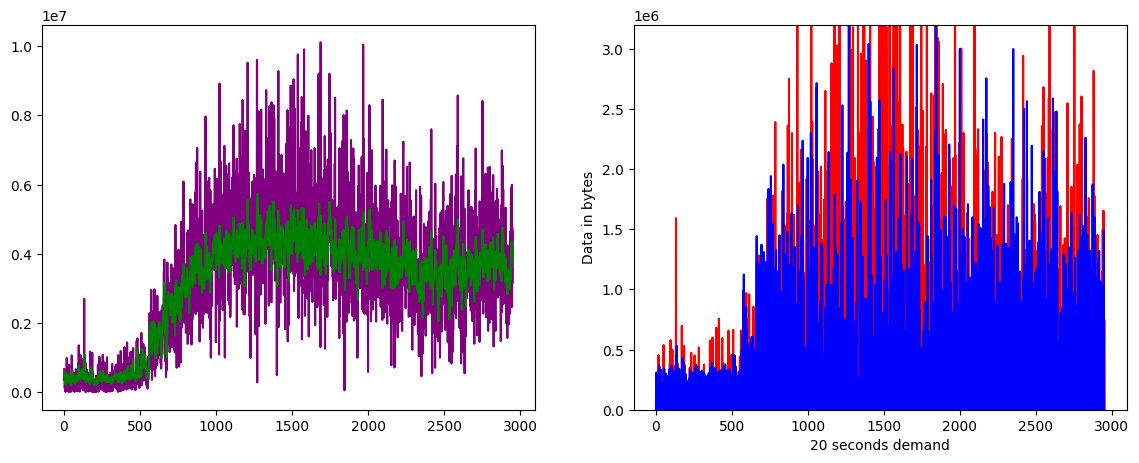

<Figure size 1400x500 with 0 Axes>

3478439
1/1 [==============================] - 0s 34ms/step
3905869
1/1 [==============================] - 0s 29ms/step


KeyboardInterrupt: 

In [11]:
# Run the simulation
start_simulation()